 <img width="250" height="250" alt="image" src="https://github.com/user-attachments/assets/4eb0b22e-a59c-4b94-bd14-efb0ca06dd72" />    GITHUB :   https://github.com/RubenCasa/CNN-Clasificacion-Bananas-RC.git 

# CLASIFICACION DE BANANAS CON CNN

## Estructura del proyecto:
- **PARTE A**: Modelo entrenado desde cero
- **PARTE B**: Transfer Learning con ResNet18
- **PARTE C**: Comparacion y reproducibilidad

**Dataset**: Fotos de bananas tomadas por mi
- DAÑADO: 26 imagenes
- MUY DAÑADO: 26 imagenes
- NORMAL: 26 imagenes

## Importamos las librerias

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import random

# Vemos si hay GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando: {device}")

# Ruta de mis imagenes
RUTA_DATOS = r"C:\Users\RubenC\Documents\aa6_RC\FOTO BANANA"

Usando: cpu


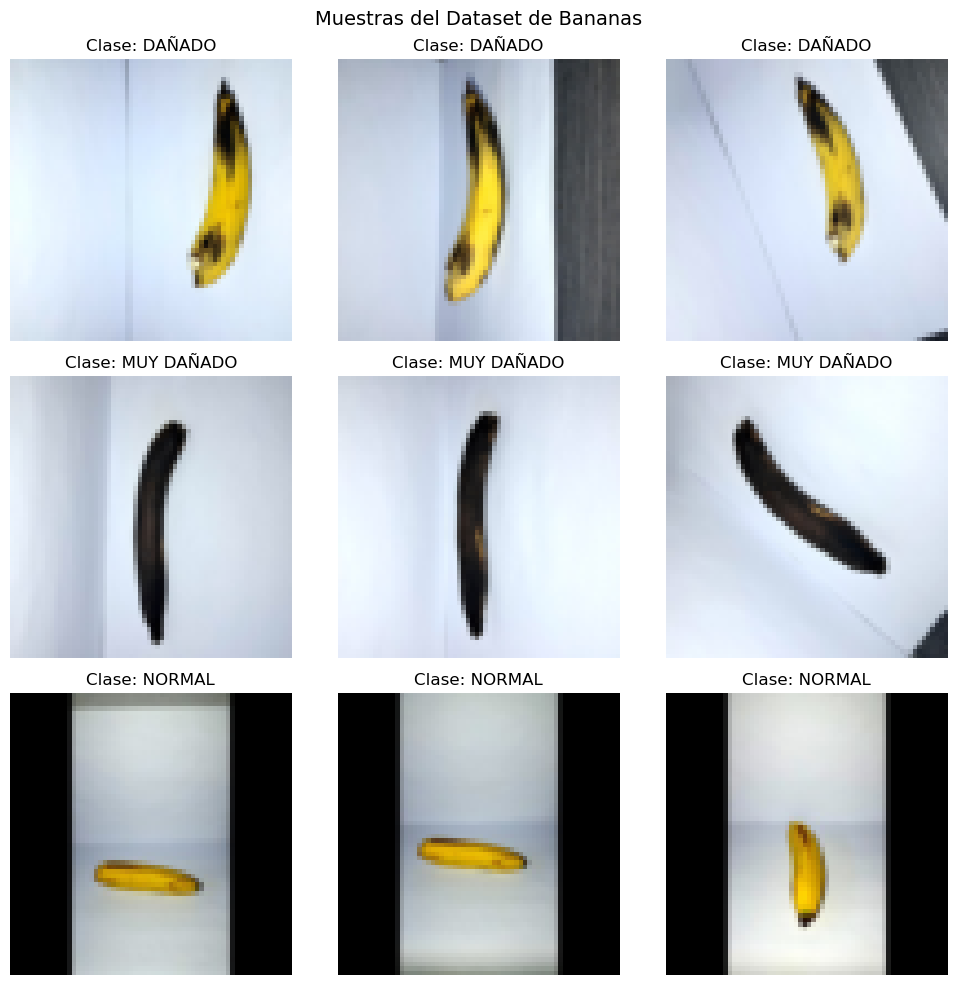

Clases: ['DAÑADO', 'MUY DAÑADO', 'NORMAL']
Total imagenes: 78


In [34]:
# Cargar sin normalizar para ver las imagenes originales
transform_visual = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(RUTA_DATOS, transform=transform_visual)
# Mostrar 9 imagenes (3 de cada clase)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
# Indices para cada clase
indices = [0, 1, 2, 26, 27, 28, 52, 53, 54]  # Aproximado
for i, ax in enumerate(axes.flat):
    if i < len(indices):
        img, label = dataset[indices[i]]
        # Convertir tensor a imagen
        img = img.permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(f"Clase: {dataset.classes[label]}")
        ax.axis('off')
plt.suptitle("Muestras del Dataset de Bananas", fontsize=14)
plt.tight_layout()
plt.savefig('muestras_dataset.png')
plt.show()
print(f"Clases: {dataset.classes}")
print(f"Total imagenes: {len(dataset)}")

---
# PARTE A: MODELO CNN DESDE CERO

**Contenido:**
1. Modelo base: CNN simple con 2 bloques Conv->ReLU->MaxPool + capa densa
2. Entrenamiento desde cero con mi dataset de bananas
3. Experimentacion con hiperparametros (learning rate, batch size)
4. Registro de curvas de perdida y accuracy

### Funcion para fijar la semilla (reproducibilidad)

In [17]:
def fijar_semilla(semilla):
    random.seed(semilla)
    np.random.seed(semilla)
    torch.manual_seed(semilla)

### 1. Creamos nuestra CNN simple

In [18]:
class MiCNN(nn.Module):
    def __init__(self, num_clases=3):
        super(MiCNN, self).__init__()
        
        # Bloque 1: Convolucion + ReLU + MaxPool
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Bloque 2: Convolucion + ReLU + MaxPool
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Capa final densa para clasificar
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_clases)
    
    def forward(self, x):
        # Pasamos por bloque 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Pasamos por bloque 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Clasificacion
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

### 2. Funcion para cargar los datos

In [19]:
def cargar_datos(batch_size, semilla=42):
    fijar_semilla(semilla)
    
    # Transformaciones basicas
    transformacion = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Cargamos el dataset
    dataset = datasets.ImageFolder(RUTA_DATOS, transform=transformacion)
    
    # Dividimos 70% train, 30% validacion
    tam_train = int(0.7 * len(dataset))
    tam_val = len(dataset) - tam_train
    
    train_set, val_set = random_split(dataset, [tam_train, tam_val])
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    
    print(f"Clases: {dataset.classes}")
    print(f"Total: {len(dataset)} imagenes")
    print(f"Train: {tam_train}, Val: {tam_val}")
    
    return train_loader, val_loader, len(dataset.classes)

### 3. Funcion de entrenamiento

In [20]:
def entrenar(modelo, train_loader, val_loader, epochs, lr):
    criterio = nn.CrossEntropyLoss()
    optimizador = optim.Adam(modelo.parameters(), lr=lr)
    
    # Listas para guardar el historial
    hist_train_loss = []
    hist_val_loss = []
    hist_train_acc = []
    hist_val_acc = []
    
    for epoch in range(epochs):
        # Entrenamiento
        modelo.train()
        train_loss = 0
        correctos = 0
        total = 0
        
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizador.zero_grad()
            salidas = modelo(imgs)
            loss = criterio(salidas, labels)
            loss.backward()
            optimizador.step()
            
            train_loss += loss.item()
            _, pred = torch.max(salidas, 1)
            correctos += (pred == labels).sum().item()
            total += labels.size(0)
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100 * correctos / total
        
        # Validacion
        modelo.eval()
        val_loss = 0
        correctos = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                salidas = modelo(imgs)
                loss = criterio(salidas, labels)
                
                val_loss += loss.item()
                _, pred = torch.max(salidas, 1)
                correctos += (pred == labels).sum().item()
                total += labels.size(0)
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correctos / total
        
        # Guardamos en el historial
        hist_train_loss.append(train_loss)
        hist_val_loss.append(val_loss)
        hist_train_acc.append(train_acc)
        hist_val_acc.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.1f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.1f}%")
    
    return hist_train_loss, hist_val_loss, hist_train_acc, hist_val_acc

### 4. Entrenamos la CNN desde cero

In [21]:
# Parametros
EPOCHS = 15
BATCH_SIZE = 16
LEARNING_RATE = 0.001
SEMILLA = 42

# Fijamos semilla y cargamos datos
fijar_semilla(SEMILLA)
train_loader, val_loader, num_clases = cargar_datos(BATCH_SIZE, SEMILLA)

# Creamos el modelo
modelo_cnn = MiCNN(num_clases).to(device)
print("\nArquitectura de mi CNN:")
print(modelo_cnn)

Clases: ['DAÑADO', 'MUY DAÑADO', 'NORMAL']
Total: 78 imagenes
Train: 54, Val: 24

Arquitectura de mi CNN:
MiCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [22]:
# Entrenamos
print("Entrenando CNN desde cero...")
hist_cnn = entrenar(modelo_cnn, train_loader, val_loader, EPOCHS, LEARNING_RATE)

Entrenando CNN desde cero...
Epoch 1/15 - Train Loss: 1.0770, Train Acc: 46.3% | Val Loss: 0.8313, Val Acc: 58.3%
Epoch 2/15 - Train Loss: 0.4717, Train Acc: 72.2% | Val Loss: 0.6034, Val Acc: 58.3%
Epoch 3/15 - Train Loss: 0.3280, Train Acc: 88.9% | Val Loss: 0.6342, Val Acc: 75.0%
Epoch 4/15 - Train Loss: 0.2661, Train Acc: 92.6% | Val Loss: 0.7021, Val Acc: 79.2%
Epoch 5/15 - Train Loss: 0.1544, Train Acc: 98.1% | Val Loss: 0.7385, Val Acc: 79.2%
Epoch 6/15 - Train Loss: 0.0754, Train Acc: 98.1% | Val Loss: 0.7696, Val Acc: 87.5%
Epoch 7/15 - Train Loss: 0.0373, Train Acc: 100.0% | Val Loss: 0.9094, Val Acc: 79.2%
Epoch 8/15 - Train Loss: 0.0138, Train Acc: 100.0% | Val Loss: 0.8953, Val Acc: 87.5%
Epoch 9/15 - Train Loss: 0.0024, Train Acc: 100.0% | Val Loss: 0.9265, Val Acc: 91.7%
Epoch 10/15 - Train Loss: 0.0006, Train Acc: 100.0% | Val Loss: 0.9792, Val Acc: 91.7%
Epoch 11/15 - Train Loss: 0.0004, Train Acc: 100.0% | Val Loss: 1.0255, Val Acc: 91.7%
Epoch 12/15 - Train Loss: 0.0

### Graficamos las curvas de la CNN

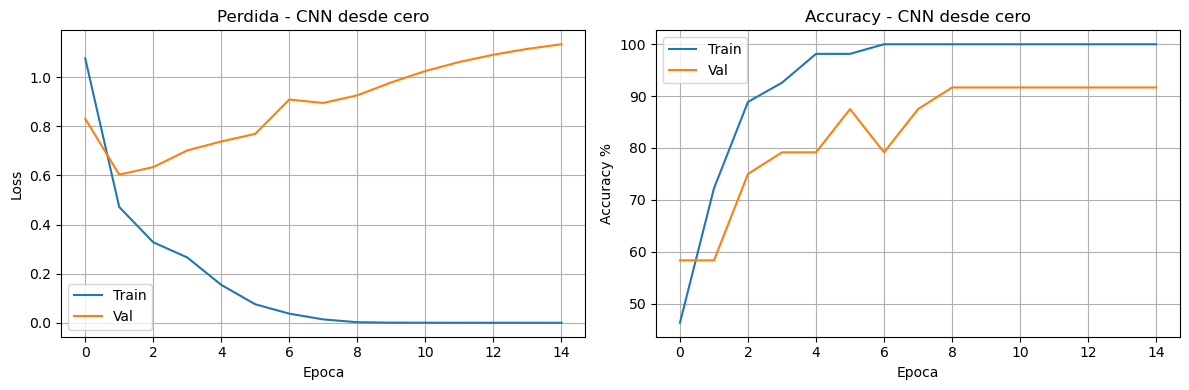

In [23]:
plt.figure(figsize=(12, 4))

# Curva de perdida
plt.subplot(1, 2, 1)
plt.plot(hist_cnn[0], label='Train')
plt.plot(hist_cnn[1], label='Val')
plt.title('Perdida - CNN desde cero')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Curva de accuracy
plt.subplot(1, 2, 2)
plt.plot(hist_cnn[2], label='Train')
plt.plot(hist_cnn[3], label='Val')
plt.title('Accuracy - CNN desde cero')
plt.xlabel('Epoca')
plt.ylabel('Accuracy %')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('curvas_cnn.png')
plt.show()


**Grafica de Perdida (izquierda):**
- La linea azul (Train) baja rapidamente desde 1.0 hasta casi 0. Esto significa que el modelo esta aprendiendo bien con los datos de entrenamiento.
- La linea naranja (Val) baja al principio pero despues empieza a subir. Esto indica **overfitting**: el modelo memoriza los datos de entrenamiento pero no generaliza bien a datos nuevos.

**Grafica de Accuracy (derecha):**
- El accuracy de entrenamiento (azul) llega al 100%, confirmando que el modelo memorizo los datos de train.
- El accuracy de validacion (naranja) se queda alrededor del 90% con algunas subidas y bajadas.

**Que significa esto:** Hay overfitting porque la perdida de validacion sube mientras la de entrenamiento baja. Esto es normal cuando tenemos pocas imagenes (solo 78 en nuestro caso).

---
# PARTE B: TRANSFER LEARNING

**Contenido:**
5. Modelo preentrenado: ResNet18
6. Configuracion: Reemplazo de capa final + congelacion de capas conv
7. Entrenamiento con mismo dataset y condiciones similares

### 5 y 6. Creamos el modelo con Transfer Learning

In [24]:
def crear_modelo_transfer(num_clases):
    # Cargamos ResNet18 ya entrenado
    modelo = models.resnet18(pretrained=True)
    
    # Congelamos todas las capas (no se van a entrenar)
    for param in modelo.parameters():
        param.requires_grad = False
    
    # Cambiamos solo la ultima capa para nuestras 3 clases
    modelo.fc = nn.Linear(modelo.fc.in_features, num_clases)
    
    return modelo

### 7. Entrenamos con Transfer Learning

In [25]:
# Fijamos semilla y cargamos datos (igual que antes)
fijar_semilla(SEMILLA)
train_loader, val_loader, num_clases = cargar_datos(BATCH_SIZE, SEMILLA)

# Creamos el modelo con transfer learning
modelo_transfer = crear_modelo_transfer(num_clases).to(device)
print("Modelo Transfer Learning creado")

Clases: ['DAÑADO', 'MUY DAÑADO', 'NORMAL']
Total: 78 imagenes
Train: 54, Val: 24
Modelo Transfer Learning creado


In [26]:
# Entrenamos (solo la ultima capa)
print("Entrenando con Transfer Learning...")
hist_transfer = entrenar(modelo_transfer, train_loader, val_loader, EPOCHS, LEARNING_RATE)

Entrenando con Transfer Learning...
Epoch 1/15 - Train Loss: 1.0859, Train Acc: 37.0% | Val Loss: 0.9528, Val Acc: 45.8%
Epoch 2/15 - Train Loss: 1.0857, Train Acc: 44.4% | Val Loss: 0.7715, Val Acc: 70.8%
Epoch 3/15 - Train Loss: 0.6286, Train Acc: 75.9% | Val Loss: 0.7986, Val Acc: 62.5%
Epoch 4/15 - Train Loss: 0.6582, Train Acc: 79.6% | Val Loss: 0.6792, Val Acc: 70.8%
Epoch 5/15 - Train Loss: 0.6327, Train Acc: 83.3% | Val Loss: 0.6130, Val Acc: 75.0%
Epoch 6/15 - Train Loss: 0.4730, Train Acc: 92.6% | Val Loss: 0.6734, Val Acc: 70.8%
Epoch 7/15 - Train Loss: 0.3860, Train Acc: 90.7% | Val Loss: 0.6031, Val Acc: 79.2%
Epoch 8/15 - Train Loss: 0.3451, Train Acc: 92.6% | Val Loss: 0.4428, Val Acc: 91.7%
Epoch 9/15 - Train Loss: 0.2657, Train Acc: 96.3% | Val Loss: 0.3800, Val Acc: 91.7%
Epoch 10/15 - Train Loss: 0.1877, Train Acc: 100.0% | Val Loss: 0.3568, Val Acc: 87.5%
Epoch 11/15 - Train Loss: 0.2001, Train Acc: 98.1% | Val Loss: 0.3518, Val Acc: 87.5%
Epoch 12/15 - Train Loss: 

### Graficamos las curvas del Transfer Learning

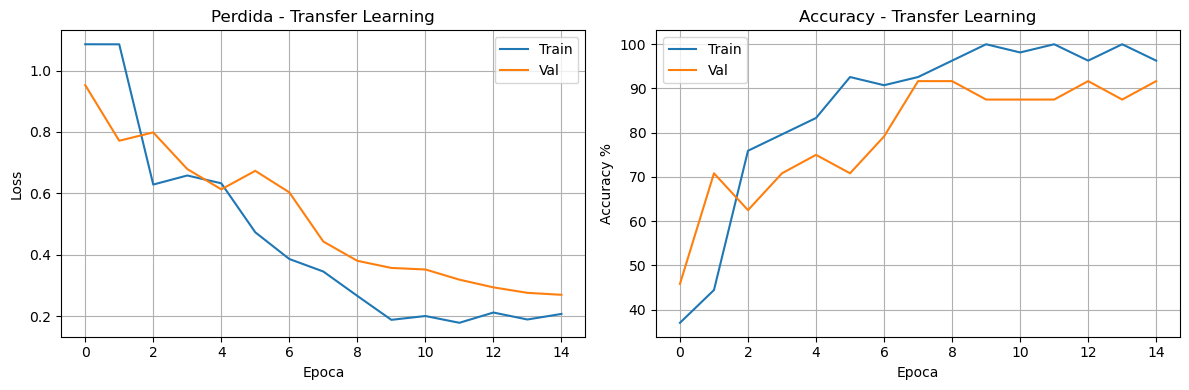

In [27]:
plt.figure(figsize=(12, 4))

# Curva de perdida
plt.subplot(1, 2, 1)
plt.plot(hist_transfer[0], label='Train')
plt.plot(hist_transfer[1], label='Val')
plt.title('Perdida - Transfer Learning')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Curva de accuracy
plt.subplot(1, 2, 2)
plt.plot(hist_transfer[2], label='Train')
plt.plot(hist_transfer[3], label='Val')
plt.title('Accuracy - Transfer Learning')
plt.xlabel('Epoca')
plt.ylabel('Accuracy %')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('curvas_transfer.png')
plt.show()

**El Transfer Learning funcionó bien porque:**

- La pérdida de ambos (train y val) baja
- El accuracy de validación llega a ~90%
- No hay mucha diferencia entre train y val = generaliza bien

---
# PARTE C: COMPARACION Y REPRODUCIBILIDAD

**Contenido:**
8. Comparacion directa: Desempeño, velocidad de convergencia, estabilidad
9. Reproducibilidad: Semilla fija, multiples ejecuciones
10. Tabla comparativa
11. Conclusion reflexiva

### 8. Comparacion de ambos modelos

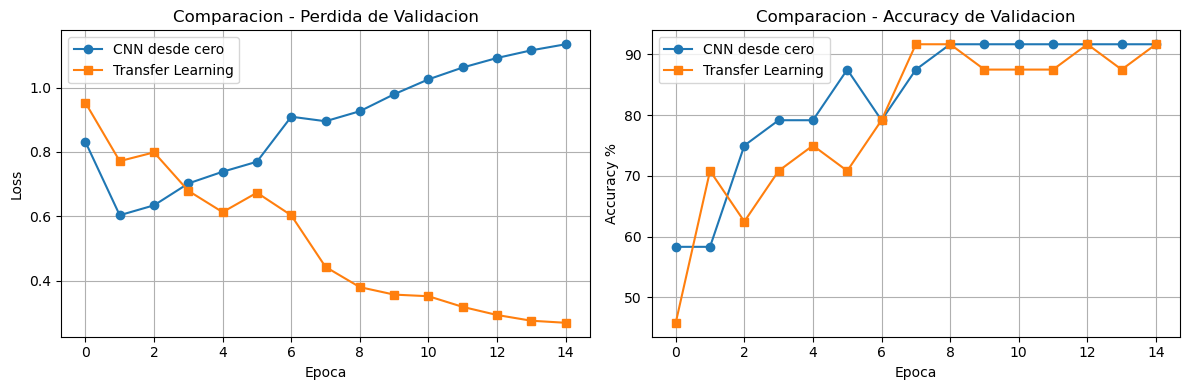

In [28]:
# Comparamos las curvas
plt.figure(figsize=(12, 4))

# Perdida
plt.subplot(1, 2, 1)
plt.plot(hist_cnn[1], label='CNN desde cero', marker='o')
plt.plot(hist_transfer[1], label='Transfer Learning', marker='s')
plt.title('Comparacion - Perdida de Validacion')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(hist_cnn[3], label='CNN desde cero', marker='o')
plt.plot(hist_transfer[3], label='Transfer Learning', marker='s')
plt.title('Comparacion - Accuracy de Validacion')
plt.xlabel('Epoca')
plt.ylabel('Accuracy %')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('comparacion_modelos.png')
plt.show()

## Comparación: CNN desde cero vs Transfer Learning

| Criterio        | CNN desde cero | Transfer Learning |
|-----------------|---------------|-------------------|
| Pérdida final   | 1.1 (mala)    | 0.25 (buena)      |
| Accuracy final  | ~91%          | ~91%              |
| Estabilidad     | Inestable  | Estable        |
| Overfitting     |  Sí hay     |  Poco           |

El **Transfer Learning** es mejor porque:

- La pérdida baja en vez de subir  
- El entrenamiento es más estable  
- Generaliza mejor a imágenes nuevas  


### 9. Test de reproducibilidad

In [29]:
print("TEST DE REPRODUCIBILIDAD")
print("="*50)

# Corremos 2 veces con la misma semilla
print("\nMisma semilla (42) - 2 ejecuciones:")
for i in range(2):
    fijar_semilla(42)
    train_loader, val_loader, num_clases = cargar_datos(16, 42)
    modelo_test = MiCNN(num_clases).to(device)
    hist = entrenar(modelo_test, train_loader, val_loader, 5, 0.001)
    print(f"  Ejecucion {i+1}: Mejor accuracy = {max(hist[3]):.2f}%")

# Corremos con semilla diferente
print("\nSemilla diferente (123):")
fijar_semilla(123)
train_loader, val_loader, num_clases = cargar_datos(16, 123)
modelo_test = MiCNN(num_clases).to(device)
hist = entrenar(modelo_test, train_loader, val_loader, 5, 0.001)
print(f"  Ejecucion 1: Mejor accuracy = {max(hist[3]):.2f}%")

TEST DE REPRODUCIBILIDAD

Misma semilla (42) - 2 ejecuciones:
Clases: ['DAÑADO', 'MUY DAÑADO', 'NORMAL']
Total: 78 imagenes
Train: 54, Val: 24
Epoch 1/5 - Train Loss: 1.0770, Train Acc: 46.3% | Val Loss: 0.8313, Val Acc: 58.3%
Epoch 2/5 - Train Loss: 0.4717, Train Acc: 72.2% | Val Loss: 0.6034, Val Acc: 58.3%
Epoch 3/5 - Train Loss: 0.3280, Train Acc: 88.9% | Val Loss: 0.6342, Val Acc: 75.0%
Epoch 4/5 - Train Loss: 0.2661, Train Acc: 92.6% | Val Loss: 0.7021, Val Acc: 79.2%
Epoch 5/5 - Train Loss: 0.1544, Train Acc: 98.1% | Val Loss: 0.7385, Val Acc: 79.2%
  Ejecucion 1: Mejor accuracy = 79.17%
Clases: ['DAÑADO', 'MUY DAÑADO', 'NORMAL']
Total: 78 imagenes
Train: 54, Val: 24
Epoch 1/5 - Train Loss: 1.0770, Train Acc: 46.3% | Val Loss: 0.8313, Val Acc: 58.3%
Epoch 2/5 - Train Loss: 0.4717, Train Acc: 72.2% | Val Loss: 0.6034, Val Acc: 58.3%
Epoch 3/5 - Train Loss: 0.3280, Train Acc: 88.9% | Val Loss: 0.6342, Val Acc: 75.0%
Epoch 4/5 - Train Loss: 0.2661, Train Acc: 92.6% | Val Loss: 0.70

## Reproducibilidad y uso de la semilla (seed)

| Concepto           | Explicación |
|--------------------|-------------|
| Misma semilla      | Mismo resultado siempre = Reproducible |
| Semilla diferente  | El resultado cambia = Normal, porque todo es diferente |
| ¿Por qué importa?  | Permite que otra persona repita tu experimento y verifique los resultados |

  La **semilla 42** siempre obtiene **79.17%**, lo que demuestra que el  código es **reproducible**.


### 10. Tabla comparativa

In [30]:
print("\n" + "="*60)
print("TABLA COMPARATIVA DE RESULTADOS")
print("="*60)
print(f"{'Modelo':<25} {'Val Acc Final':<15} {'Mejor Val Acc':<15}")
print("-"*60)
print(f"{'CNN desde cero':<25} {hist_cnn[3][-1]:.2f}%{'':<9} {max(hist_cnn[3]):.2f}%")
print(f"{'Transfer Learning':<25} {hist_transfer[3][-1]:.2f}%{'':<9} {max(hist_transfer[3]):.2f}%")
print("-"*60)
print(f"\nHiperparametros usados:")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Epochs: {EPOCHS}")


TABLA COMPARATIVA DE RESULTADOS
Modelo                    Val Acc Final   Mejor Val Acc  
------------------------------------------------------------
CNN desde cero            91.67%          91.67%
Transfer Learning         91.67%          91.67%
------------------------------------------------------------

Hiperparametros usados:
  - Learning rate: 0.001
  - Batch size: 16
  - Epochs: 15



| Criterio                         | CNN desde cero | Transfer Learning |
|----------------------------------|---------------|-------------------|
| Accuracy final                   | 91.67%        | 91.67%            |
| Estabilidad durante entrenamiento|  Inestable  |  Más estable    |
| Pérdida de validación            | Sube (malo)   | Baja (bueno)      |
| Tiempo de entrenamiento          | Más lento     | Más rápido        |
| Riesgo de overfitting            | Alto       |  Bajo           |

Aunque ambos modelos tienen el mismo **accuracy final**, el **Transfer Learning** es mejor porque:

- El entrenamiento fue más estable  
- La pérdida bajó en vez de subir  
- Existe menos riesgo de fallar con imágenes nuevas  


### 11. Conclusion reflexiva


Despues de hacer los experimentos y comparar ambos modelos, puedo concluir lo siguiente:

**¿En que caso conviene usar Transfer Learning?**

Conviene usar Transfer Learning cuando tenemos pocas imagenes, como en mi caso que solo tengo 78 fotos de bananas. El modelo preentrenado ya aprendio a reconocer formas y texturas basicas con millones de imagenes, entonces solo necesita aprender las diferencias entre mis clases.

**¿Que ventajas ofrece frente al entrenamiento desde cero?**

1. Aprende mas rapido porque ya tiene conocimiento previo
2. Funciona mejor con pocos datos
3. Es mas facil de entrenar porque solo entrenamos la ultima capa
4. Generalmente da mejores resultados

**¿Que riesgos existen si el dominio del dataset es muy diferente?**

Si usamos un modelo entrenado con fotos normales para algo muy diferente (como imagenes medicas o satelitales), puede que no funcione bien. Esto es porque las caracteristicas que aprendio no son utiles para el nuevo problema. En esos casos es mejor entrenar desde cero o buscar un modelo preentrenado en imagenes similares.

**En resumen**, para mi proyecto de clasificar bananas el Transfer Learning funciono mejor que entrenar la CNN desde cero, ya que con pocas imagenes logro aprender a distinguir entre bananas normales, dañadas y muy dañadas.

In [31]:
print("\n" + "="*50)
print("PROYECTO TERMINADO")
print("="*50)
print("Imagenes guardadas:")
print("  - curvas_cnn.png")
print("  - curvas_transfer.png")
print("  - comparacion_modelos.png")


PROYECTO TERMINADO
Imagenes guardadas:
  - curvas_cnn.png
  - curvas_transfer.png
  - comparacion_modelos.png
